Sentiments Analyisis for Restaurant Review

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [ ]:
# Load and preprocess your restaurant reviews dataset (assuming you have a CSV file)
df = pd.read_csv('/content/drive/MyDrive/IBM Skillbuild /Restaurant_Reviews_dataset.csv')

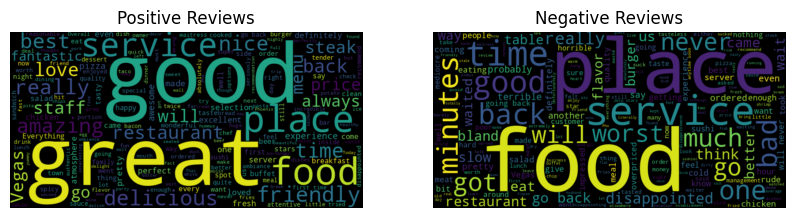

In [ ]:

# Plot the word cloud for positive and negative reviews
positive_words = ' '.join(df[df['Liked'] == 1]['Review'].tolist())
wordcloud_positive = WordCloud(width=800, height=400).generate(positive_words)

negative_words = ' '.join(df[df['Liked'] == 0]['Review'].tolist())
wordcloud_negative = WordCloud(width=800, height=400).generate(negative_words)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Review'], df['Liked'], test_size=0.2, random_state=42)

##  Option 1: Traditional Machine Learning with TF-IDF features and Logistic Regression

In [ ]:
# Option 1: Traditional Machine Learning with TF-IDF features and Logistic Regression
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
model_lr = LogisticRegression(max_iter=500)
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

In [ ]:
print("Traditional Machine Learning (Logistic Regression) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr) * 100 ,'%')
print(classification_report(y_test, y_pred_lr))


Traditional Machine Learning (Logistic Regression) Results:
Accuracy: 79.5 %
              precision    recall  f1-score   support

           0       0.75      0.85      0.80        96
           1       0.85      0.74      0.79       104

    accuracy                           0.80       200
   macro avg       0.80      0.80      0.79       200
weighted avg       0.80      0.80      0.79       200



## Option 2: Deep Learning with BERT

In [ ]:
# Option 2: Deep Learning with BERT
# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Tokenize and encode the text data
def tokenize_text(texts, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in tqdm(texts, desc="Tokenizing"):
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [ ]:
# Tokenize and encode training and testing data
X_train_input_ids, X_train_attention_masks = tokenize_text(X_train, tokenizer)
X_test_input_ids, X_test_attention_masks = tokenize_text(X_test, tokenizer)

Tokenizing:   0%|          | 0/800 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Tokenizing: 100%|██████████| 200/200 [00:00<00:00, 1501.38it/s]


In [ ]:
# Convert labels to tensors
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)

In [ ]:
# Create data loaders
batch_size = 32
train_data = TensorDataset(X_train_input_ids, X_train_attention_masks, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)



In [ ]:
# Training parameters
epochs = 5
learning_rate = 2e-5
optimizer = AdamW(model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()

        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}/{epochs} - Average Loss: {avg_loss}")

Epoch 1/5 - Average Loss: 0.8286651396751403
Epoch 2/5 - Average Loss: 0.4640677982568741
Epoch 3/5 - Average Loss: 0.16617004334926605
Epoch 4/5 - Average Loss: 0.06291328437626362
Epoch 5/5 - Average Loss: 0.03681532334536314


In [ ]:
# Evaluate the model on the test set
model.eval()
y_pred_bert = []

test_data = TensorDataset(X_test_input_ids, X_test_attention_masks, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits

    y_pred_bert.extend(np.argmax(logits.cpu().numpy(), axis=1))

In [ ]:
print("BERT Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_bert) * 100,'%')
print(classification_report(y_test, y_pred_bert))6


BERT Model Results:
Accuracy: 96.5 %
              precision    recall  f1-score   support

           0       0.94      0.99      0.96        96
           1       0.99      0.94      0.97       104

    accuracy                           0.96       200
   macro avg       0.97      0.97      0.96       200
weighted avg       0.97      0.96      0.97       200

